In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import StratifiedKFold
import xgboost as xgb


types = {
         'row_id': np.dtype(int),
         'x': np.dtype(float),
         'y' : np.dtype(float),
         'accuracy': np.dtype(int),
         'place_id': np.dtype(int)
        }

df_train = pd.read_csv('train_facebook.csv', index_col=0, nrows=10000)
df_test = pd.read_csv('test_facebook.csv', index_col=0, nrows=10000)
df_sub = pd.read_csv('sample_submission_facebook.csv', index_col=0)  

def filter_df(df_train, df_test):
    df_train = df_train[(df_train['x'] > 1) & (df_train['x'] < 1.25) &
                        (df_train['y'] > 2.5) & (df_train['y'] < 2.75)]

    df_test = df_test[(df_test['x'] > 1) & (df_test['x'] < 1.25) &
                      (df_test['y'] > 2.5) & (df_test['y'] < 2.75)]
    return df_train, df_test

def fe(df, eps, n_cell_x, n_cell_y):
    new_date = np.datetime64('2014-01-01T01:01', dtype='datetime64[m]')
    df_time = df['time'].apply(lambda x: pd.to_datetime(new_date + x, unit='m'))
    df['year'] = df_time.dt.year
    df['month'] = df_time.dt.month
    df['day'] = df_time.dt.day
    df['weekday'] = df_time.dt.weekday
    df['hour'] = df_time.dt.hour
    
    df['x_d_y'] = df['x'].values / (df['y'].values + eps)
    df['x_t_y'] = df['x'].values * df['y'].values
      
    size_x = 10 / n_cell_x
    size_y = 10 / n_cell_y
    xs = np.where(df['x'].values < eps, 0, df['x'].values - eps)
    ys = np.where(df['y'].values < eps, 0, df['y'].values - eps)
    pos_x = (xs / size_x).astype(np.int)
    pos_y = (ys / size_y).astype(np.int)
    df['grid_cell'] = pos_y * n_cell_x + pos_x
    df = df.drop(['time'], axis=1)
    
    cols = ['x', 'y', 'accuracy', 'x_d_y', 'x_t_y', 
            'hour', 'weekday', 'day', 'month', 'year']
    for cl in cols:
        ave = df_train[cl].mean()
        std = df_train[cl].std()
        df[cl] = (df[cl].values - ave ) / std 
    return df

def process(train, test):
    range_list = [i for i in range(2)]
    train_cell = train[train['grid_cell'].isin(range_list)]
    train_count = train_cell['place_id'].value_counts()
    train_fliter = train_count[train_cell['place_id'].values] >= 1
    train_cell = train_cell[train_fliter.values]
    
    test_cell = test[test['grid_cell'].isin(range_list)]
    return train_cell, test_cell

def model(train, test):
    n_folds = 3
    train_set, test_set = process(train, test)
    le = LabelEncoder()
    y_train = le.fit_transform(train_set['place_id'].values)
    x_train = train_set.drop(['place_id', 'grid_cell'], axis=1).values
    x_test = test_set.drop(['grid_cell'], axis=1).values
    
    clfs = [
            RandomForestClassifier(n_estimators=100, n_jobs=-1),
            GradientBoostingClassifier(n_estimators = 100),
            xgb.XGBClassifier(n_estimators=10)
           ]
    
    skf = list(StratifiedKFold(y_train, n_folds))
    
    blend_train = np.zeros((x_train.shape[0], len(clfs)))
    blend_test = np.zeros((x_test.shape[0], len(clfs)))
    
    for j, clf in enumerate(clfs):
        blend_test_j = np.zeros((x_test.shape[0], len(skf)))
        
        for i, (train_index, cv_index) in enumerate(skf):
            print('Fold [{}]'.format(i + 1))
            
            X_train = x_train[train_index]
            Y_train = y_train[train_index]
            X_cv = x_train[cv_index]
            Y_cv = y_train[cv_index]
            
            clf.fit(X_train, Y_train)

            blend_train[cv_index, j] = clf.predict(X_cv)
            blend_test_j[:, i] = clf.predict(x_test)
            
        blend_test[:, j] = blend_test_j.mean(1)

    bclf = SGDClassifier(loss='modified_huber', n_iter=1, random_state=0, n_jobs=-1) 
    bclf.fit(blend_train, y_train)
    
    y_predict = bclf.predict_proba(blend_test)
    red_labels = le.inverse_transform(np.argsort(y_predict, axis=1)[:,::-1][:,:3])
    str_labels = np.apply_along_axis(lambda x: ' '.join(x.astype(str)), 1, red_labels)
    df_sub.loc[test_set.index] = str_labels.reshape(-1,1)
    return df_sub.to_csv('sub_facebook.csv', index=True)

#df_train, df_test = filter_df(df_train, df_test)
train_set = fe(df_train, 0.00001, 10, 10)
test_set = fe(df_test, 0.00001, 10, 10)
model(train_set, test_set)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


Fold [1]
Fold [2]
Fold [3]
Fold [1]
Fold [2]
Fold [3]
Fold [1]
Fold [2]
Fold [3]


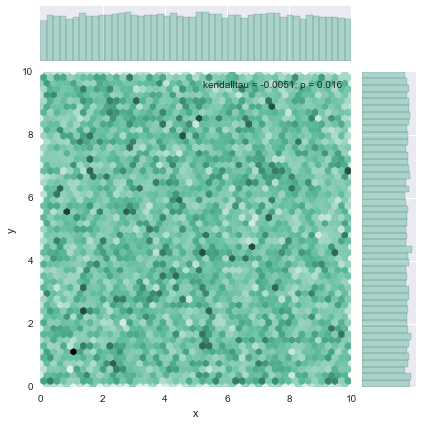

In [132]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df_train = pd.read_csv('train_facebook.csv', nrows=100000)

x = df_train['x']
y = df_train['y']

sns.jointplot(x, y, kind="hex", stat_func=kendalltau, color="#4CB391")

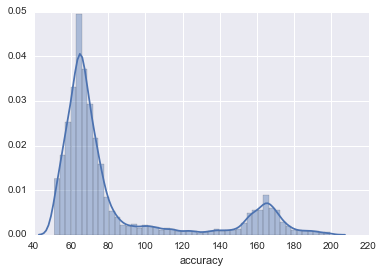

In [108]:
accuracy = df_train['accuracy'][(df_train['accuracy'] > 50) & 
                                (df_train['accuracy'] < 200)]
sns.distplot(accuracy)

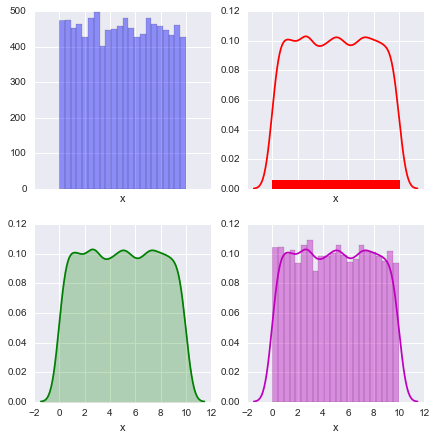

In [114]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.despine(left=True)

sns.distplot(x, kde=False, color="b", ax=axes[0, 0])
sns.distplot(x, hist=False, rug=True, color="r", ax=axes[0, 1])
sns.distplot(x, hist=False, color="g", kde_kws={"shade": True}, ax=axes[1, 0])
sns.distplot(x, color="m", ax=axes[1, 1])

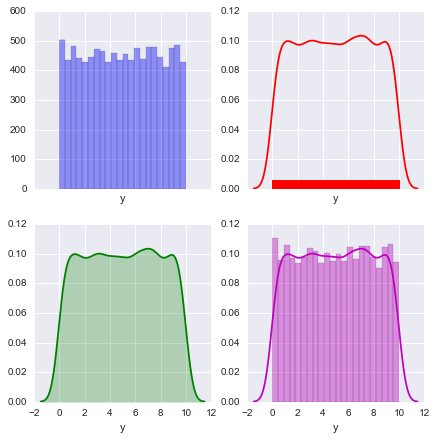

In [115]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.despine(left=True)

sns.distplot(y, kde=False, color="b", ax=axes[0, 0])
sns.distplot(y, hist=False, rug=True, color="r", ax=axes[0, 1])
sns.distplot(y, hist=False, color="g", kde_kws={"shade": True}, ax=axes[1, 0])
sns.distplot(y, color="m", ax=axes[1, 1])

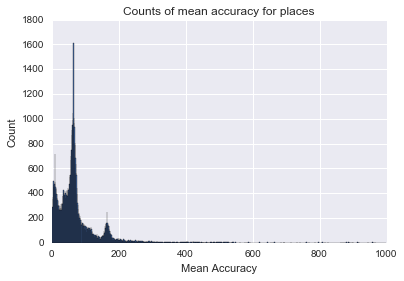

In [140]:
df = df_train.groupby('place_id').agg(['std', 'mean'])
df.fillna(0, inplace=True)
mean = df['accuracy']['mean']

p = plt.hist(mean, bins=np.arange(min(mean), max(mean)))
plt.xlabel('Mean Accuracy')
plt.ylabel('Count')
plt.title('Counts of mean accuracy for places')

plt.show()